# Лабораторная работа №3: Создание рекомендательной системы



Макарьев Максим ИДБ-22-11


## 1. Установка необходимых библиотек

In [1]:
!pip install pandas scikit-learn scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2505189 sha256=df4b3db7ddf667bbbabbe3da7725aa74f7ae51882139fb0868e6891877026964
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise


## 2. Загрузка и предварительная обработка данных

Используется датасет Movie Recommender System Dataset(https://www.kaggle.com/datasets/gargmanas/movierecommenderdataset)

In [4]:
import pandas as pd

movies_file = "movies.csv"
ratings_file = "ratings.csv"

# Загрузка данных по оценкам
data = pd.read_csv(ratings_file)

# Загрузка данных фильмов
movie_titles = pd.read_csv(movies_file, usecols=['movieId', 'title'])


# Очистка названий фильмов от лишних пробелов и кавычек
movie_titles['title'] = movie_titles['title'].str.strip().str.replace(r'^\'|\'$', '', regex=True)


# Вывод первых строк данных для проверки
print(data.head())
print(movie_titles.head())


   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
   movieId                               title
0        1                    Toy Story (1995)
1        2                      Jumanji (1995)
2        3             Grumpier Old Men (1995)
3        4            Waiting to Exhale (1995)
4        5  Father of the Bride Part II (1995)


In [5]:
# Объединение данных по movieId
data = pd.merge(data, movie_titles, on='movieId')

# Вывод первых строк данных для проверки
print(data.head())

   userId  movieId  rating  timestamp                        title
0       1        1     4.0  964982703             Toy Story (1995)
1       1        3     4.0  964981247      Grumpier Old Men (1995)
2       1        6     4.0  964982224                  Heat (1995)
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)
4       1       50     5.0  964982931   Usual Suspects, The (1995)


## 3. Анализ данных


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Установка стиля для графиков
sns.set_style('white')

# Вычисляем средний рейтинг для каждого фильма
ratings = pd.DataFrame(data.groupby('title')['rating'].mean())

# Добавляем столбец с количеством оценок для каждого фильма
ratings['num of ratings'] = data.groupby('title')['rating'].count()

# Просмотр первых 5 строк датафрейма 'ratings'
print(ratings.head())

                                               rating  num of ratings
title                                                                
(500) Days of Summer (2009)                  3.666667              42
*batteries not included (1987)               3.285714               7
...All the Marbles (1981)                    2.000000               1
...And Justice for All (1979)                3.166667               3
00 Schneider - Jagd auf Nihil Baxter (1994)  4.500000               1


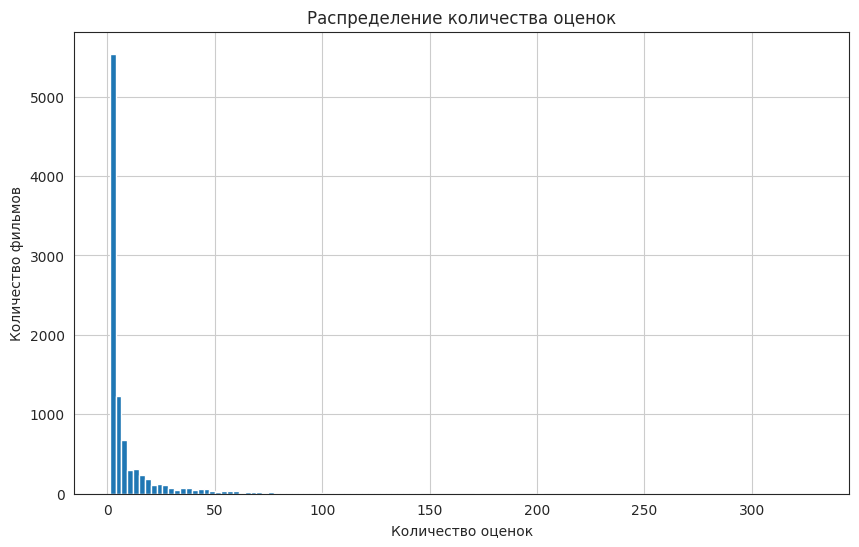

In [7]:
plt.figure(figsize=(10, 6))
ratings['num of ratings'].hist(bins=120)
plt.xlabel('Количество оценок')
plt.ylabel('Количество фильмов')
plt.title('Распределение количества оценок')
plt.show()

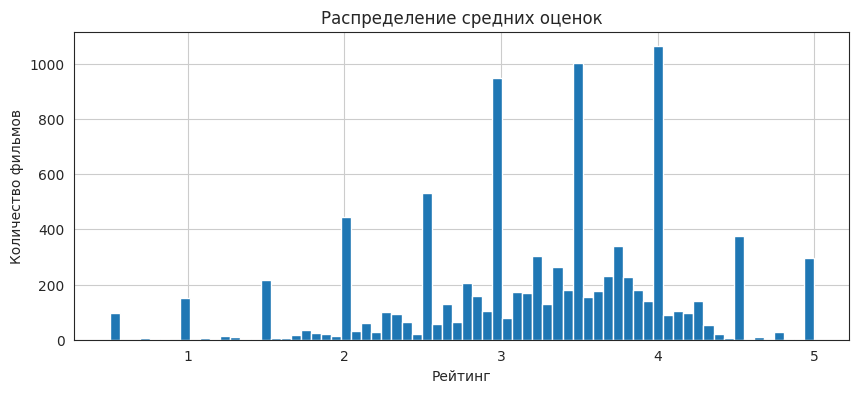

In [8]:
# Гистограмма оценок
plt.figure(figsize=(10, 4))
ratings['rating'].hist(bins=70)
plt.xlabel('Рейтинг')
plt.ylabel('Количество фильмов')
plt.title('Распределение средних оценок')
plt.show()

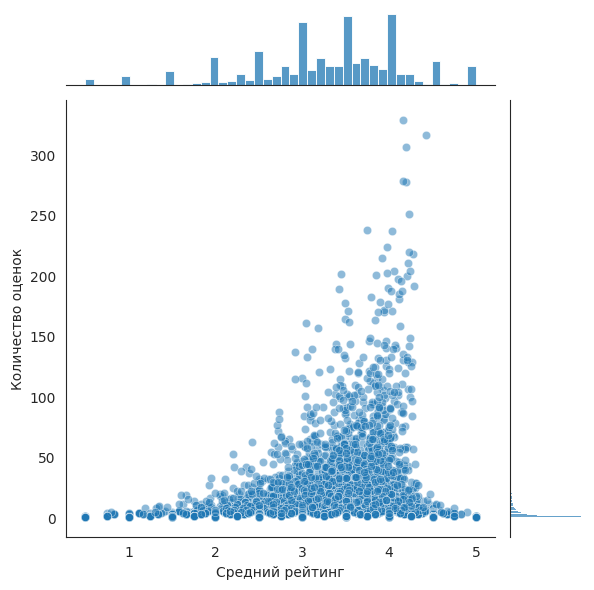

In [9]:
# Соотношение рейтинга и количества оценок
sns.jointplot(x='rating', y='num of ratings', data=ratings, alpha=0.5)
plt.xlabel('Средний рейтинг')
plt.ylabel('Количество оценок')
plt.show()

## 4. Построение рекомендательной системы на основе сходства


### 4.1 Создание матрицы пользователь-фильм


In [10]:
# Создание матрицы, где строки - пользователи, столбцы - фильмы, значения - оценки
movie_matrix = data.pivot_table(index='userId', columns='title', values='rating')
print(movie_matrix.head())

title   (500) Days of Summer (2009)  *batteries not included (1987)  \
userId                                                                
1                               NaN                             NaN   
2                               NaN                             NaN   
3                               NaN                             NaN   
4                               NaN                             NaN   
5                               NaN                             NaN   

title   ...All the Marbles (1981)  ...And Justice for All (1979)  \
userId                                                             
1                             NaN                            NaN   
2                             NaN                            NaN   
3                             NaN                            NaN   
4                             NaN                            NaN   
5                             NaN                            NaN   

title   00 Schneider - Ja

### 4.2 Вычисление корреляций между фильмами

К сожалению, для некоторых фильмов не хватает данных, поэтому функция снизу перебирает фильмы до тех пор, пока не найдет тот, у которого она может посчитать корреляцию 

In [ ]:

# Функция для поиска рекомендаций с перебором фильмов
def find_recommendations(max_attempts=10):
    attempts = 0
    checked_movies = set()

    while attempts < max_attempts:
        movie_name = movie_titles.sample(1)['title'].values[0]

        if movie_name in checked_movies:
            continue

        checked_movies.add(movie_name)

        if movie_name not in movie_matrix.columns:
            continue

        # Оценки пользователей для выбранного фильма
        movie_user_ratings = movie_matrix[movie_name]

        # Проверяем, есть ли у фильма оценки
        if movie_user_ratings.isnull().all():
            continue

        # Вычисление корреляции
        similar_to_movie = movie_matrix.corrwith(movie_user_ratings, method='pearson', drop=True)

        # Создание DataFrame с корреляциями
        corr_movie = pd.DataFrame(similar_to_movie, columns=['Correlation'])
        corr_movie.dropna(inplace=True)

        # Добавление количества оценок
        corr_movie = corr_movie.join(ratings['num of ratings'])

        # Фильтрация фильмов с количеством оценок больше 100
        recommendations = corr_movie[corr_movie['num of ratings'] > 100].sort_values('Correlation', ascending=False)

        if not recommendations.empty:
            return movie_name, recommendations.head()

        attempts += 1

    return None, "Достигнут лимит попыток, рекомендации не найдены."

# Тестируем систему
movie_name, recommendations = find_recommendations()
if recommendations is not None:
    print(f"Фильмы, похожие на '{movie_name}':")
    print(recommendations)
else:
    print(recommendations)


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.11/dist-packages/numpy/lib/

Фильмы, похожие на 'Rocket Science (2007)':
                                        Correlation  num of ratings
title                                                              
Dark Knight, The (2008)                         1.0             149
Waterworld (1995)                               1.0             115
Back to the Future (1985)                       1.0             171
Donnie Darko (2001)                             1.0             109
Monty Python and the Holy Grail (1975)          1.0             136


## 5. Построение рекомендательной системы с использованием библиотеки Surprise


In [12]:
from surprise import Dataset, Reader

# Определение формата данных для Surprise
reader = Reader(rating_scale=(1, 5))

# Загрузка данных в формат Surprise
data_surprise = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

In [13]:
from surprise import SVD
from surprise.model_selection import cross_validate

# Инициализация модели SVD
svd = SVD()

# Кросс-валидация модели
cross_validate(svd, data_surprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8725  0.8643  0.8826  0.8802  0.8673  0.8734  0.0071  
MAE (testset)     0.6712  0.6647  0.6768  0.6747  0.6695  0.6714  0.0042  
Fit time          1.09    1.20    1.02    1.01    1.03    1.07    0.07    
Test time         0.12    0.07    0.07    0.18    0.07    0.10    0.04    


{'test_rmse': array([0.87248072, 0.86433437, 0.88260559, 0.88024243, 0.86729631]),
 'test_mae': array([0.67120837, 0.66469697, 0.67683655, 0.6746737 , 0.66951903]),
 'fit_time': (1.0910489559173584,
  1.200423002243042,
  1.0194451808929443,
  1.0069124698638916,
  1.0287437438964844),
 'test_time': (0.12259364128112793,
  0.07159423828125,
  0.06866860389709473,
  0.1755046844482422,
  0.06791210174560547)}

In [14]:
# Построение полного тренировочного набора
trainset = data_surprise.build_full_trainset()

# Обучение модели
svd.fit(trainset)

In [16]:
# Идентификаторы пользователя и фильма
user_id = 1  # Пример пользователя
item_id = 7  # Пример фильма

# Фактический рейтинг (если имеется)
actual_rating = data[(data['userId'] == user_id) & (data['movieId'] == item_id)]['rating']

# Предсказанный рейтинг
predicted_rating = svd.predict(user_id, item_id).est

print(f"Фактический рейтинг: {actual_rating.values if not actual_rating.empty else 'Нет данных'}")
print(f"Предсказанный рейтинг: {predicted_rating}")

Фактический рейтинг: Нет данных
Предсказанный рейтинг: 3.8223914326988733


In [20]:
# Функция для получения рекомендаций
def get_recommendations(user_id, num_recommendations=5):
    all_item_ids = data['movieId'].unique()
    rated_items = data[data['userId'] == user_id]['movieId'].values
    predictions = [(item_id, svd.predict(user_id, item_id).est) for item_id in all_item_ids if item_id not in rated_items]
    predictions.sort(key=lambda x: x[1], reverse=True)
    top_items = predictions[:num_recommendations]
    recommended_movies = [(movie_titles[movie_titles['movieId'] == item_id]['title'].values[0], rating) for item_id, rating in top_items]
    return recommended_movies

user_id = 1
recommendations = get_recommendations(user_id, num_recommendations=10)
print(f"Топ-10 рекомендаций для пользователя {user_id}:")
for idx, (title, rating) in enumerate(recommendations, 1):
    print(f"{idx}. {title} (Предсказанный рейтинг: {rating:.2f})")


Топ-10 рекомендаций для пользователя 1:
1. Shawshank Redemption, The (1994) (Предсказанный рейтинг: 5.00)
2. Good Will Hunting (1997) (Предсказанный рейтинг: 5.00)
3. Wallace & Gromit: The Best of Aardman Animation (1996) (Предсказанный рейтинг: 5.00)
4. Philadelphia Story, The (1940) (Предсказанный рейтинг: 5.00)
5. Singin' in the Rain (1952) (Предсказанный рейтинг: 5.00)
6. Rear Window (1954) (Предсказанный рейтинг: 5.00)
7. North by Northwest (1959) (Предсказанный рейтинг: 5.00)
8. Some Like It Hot (1959) (Предсказанный рейтинг: 5.00)
9. Notorious (1946) (Предсказанный рейтинг: 5.00)
10. 12 Angry Men (1957) (Предсказанный рейтинг: 5.00)


Рекомедательная система подбирает фильмы, которые наиболее соответствуют вкусам пользователя, основываясь на его предыдущих оценках и схожести с другими фильмами